In [1]:
import sys
# sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import torch

import numpy as np
import matplotlib.pyplot as plt

import os
from model import EncoderCNN, DecoderRNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
transform_test = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.485, 0.456, 0.406), 
                                                          (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


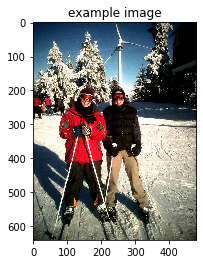

In [7]:
orig_image, image = next(iter(data_loader))

plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

if torch.cuda.is_available():
    encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
    decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
else:
    encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file), 
                                       map_location=torch.device('cpu')))
    decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),
                                       map_location=torch.device('cpu')))

encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding): Embedding(8856, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8856, bias=True)
)

## sampling

So in this assignment we use `LSTM`, not `LSTMCell` for sampling. Let's try to understand how it's possible.

In [10]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
output = decoder.sample(features)

In [11]:
output

[0, 3, 91, 77, 3, 35, 812, 130, 170, 39, 319, 18, 1, 1, 18, 1, 1, 18, 1, 1]

In [15]:
captions, states = [], None

We run `LSTM` on a single word and get a single output. Then we project it on a vocabulary space. Then we have to choose the word with max probability (greedy search). We got `0` first time (why is that?). Then we have to embed our output and run loop again.

In [17]:
features.shape

torch.Size([1, 1, 256])

In [16]:
lstm_out, states = decoder.lstm(features, states)

In [18]:
lstm_out.shape

torch.Size([1, 1, 512])

In [19]:
outputs = decoder.linear(lstm_out.squeeze(1))

In [20]:
outputs.shape

torch.Size([1, 8856])

In [24]:
outputs[0, :5]

tensor([20.0159, -0.2623,  2.8545,  5.3813, -0.3618], grad_fn=<SliceBackward>)

In [21]:
_, predicted = outputs.max(dim=1) 

In [23]:
predicted, predicted.shape

(tensor([0]), torch.Size([1]))

In [25]:
captions.append(predicted.item())

And this concludes our analysis of the inference.